### 导入库

In [1]:
import os
if os.path.split(os.getcwd())[-1] == "torchpal":
    import sys
    sys.path.append(os.getcwd())
import torch
import torch.nn as nn
import pandas as pd

### 样例数据

In [2]:
NUM_TRAIN_SAMPLES = 500
NUM_TEST_SAMPLES = 100
NUM_FEATURES = 10

train_df = pd.DataFrame(
    {"id": range(NUM_TRAIN_SAMPLES)} | 
    (tmp:={"feature_" + str(i): torch.randn(NUM_TRAIN_SAMPLES) for i in range(NUM_FEATURES)})|
    {"y": tmp["feature_0"] ** 2 + tmp["feature_1"] * 3 + tmp["feature_2"] * 4 + 5}   # 假设y只与前3个特征有关
)
test_df = pd.DataFrame(
    {"id": range(NUM_TEST_SAMPLES)} | 
    {"feature_" + str(i): torch.randn(NUM_TEST_SAMPLES) for i in range(NUM_FEATURES)}
) 

### 定义你自己的模型

In [3]:
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, output_dim),
        )

    def forward(self, X):
        return self.net(X)

### 调用 torchpal

In [4]:
import torchpal as tp

In [5]:
# 训练集
X_train = torch.tensor(train_df.drop(columns=["id", "y"]).values)
y_train = torch.tensor(train_df["y"].values).reshape(-1,1)       # 管理器接受的向量全部是二维的
# 测试集
X_test = torch.tensor(test_df.drop(columns=["id"]).values)

In [6]:
# 初始化 torchpal 管理器
manager = tp.train.RegressionManager(
    X_train=X_train,
    y_train=y_train,   
    X_test=X_test,
    net_cls=MyModel,
    net_params={"input_dim": X_train.shape[1], "hidden_dim": 64, "output_dim": 1},
    criterion_cls=nn.MSELoss,
    criterion_params={},
    optimizer_cls=torch.optim.Adam,
    optimizer_params={"lr": 0.005, "weight_decay": 0.01},
    # device="cpu" # 如果不支持cuda，请取消注释此行
)

--- 探索性训练 ---
检测到weight_decay，已自动临时视作0以屏蔽该参数


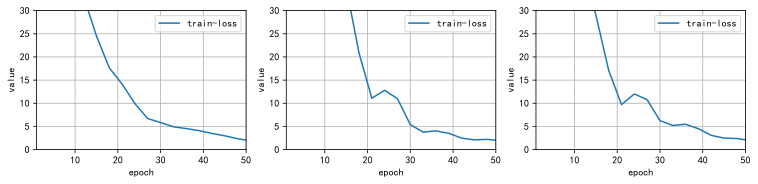

<Figure size 640x480 with 0 Axes>

In [7]:
# 探索性训练：在小数据集上快速验证
print("--- 探索性训练 ---")
manager.exploratory_train(subset_size=50, num_epochs=50, ylim=(0, 30))

--- K 折交叉验证 ---


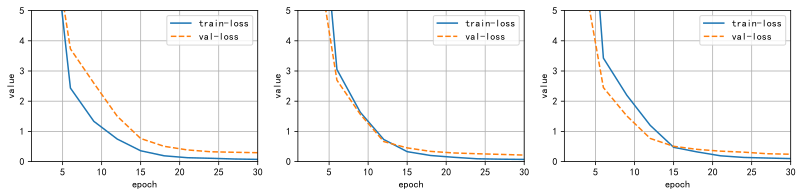

<Figure size 640x480 with 0 Axes>

In [8]:
# 训练与评估。（支持 K 折交叉验证）
print("--- K 折交叉验证 ---")
manager.train_and_eval(k_folds=3, batch_size=32, num_epochs=30, ylim=(0, 5))

--- 最终训练 ---


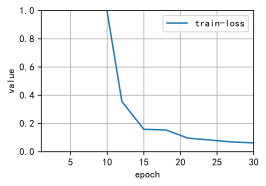

训练完成，已返回模型


<Figure size 640x480 with 0 Axes>

In [9]:
# 最终训练：在完整训练集上训练
print("--- 最终训练 ---")
final_model = manager.final_train(batch_size=32, num_epochs=30, ylim=(0, 1))

In [10]:
# 预测并保存结果
predictions = manager.predict(
    model=final_model,
    test_df=test_df,                  # 包含 ID 列的 DataFrame
    pred_col_name="target",           # 待预测的列名
    backup_src_path='./example.ipynb',   # 提供路径以备份模型
    # device="cpu"
)

模型：
model=MyModel(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
预测的结果已保存到 d:\Workspace\Vscode\Repos\torchpal\submissions\MyModel_0509_151814_pred.csv
Source file backed up to: d:\Workspace\Vscode\Repos\torchpal\backups\example_0509_151814.ipynb


### 附：其他功能

#### 自定义评估指标

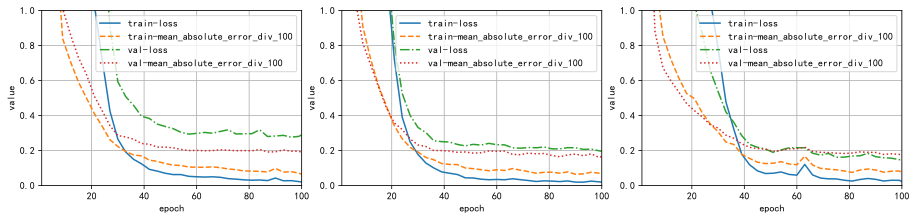

<Figure size 640x480 with 0 Axes>

In [11]:
# 自定义指标格式：(y_hat: torch.Tensor, y: torch.Tensor) -> float
def mean_absolute_error_div_100(y_hat, y):
    return (y_hat - y).abs().sum().item()/100

# 在训练/评估时通过 metric_names 传入自定义指标函数变量 "mae".（"loss", "acc"是内置的特殊名字）
manager.train_and_eval(k_folds=3, batch_size=64, num_epochs=100, metric_names=["loss", mean_absolute_error_div_100])  

#### 保存与加载模型

In [12]:
path = tp.utils.save_model_state(final_model)  # 默认保存在 state_dicts/

模型状态字典已保存到 d:\Workspace\Vscode\Repos\torchpal\state_dicts\MyModel_0509_151835.pth


In [ ]:
# 加载模型状态前，需要先实例化一个与保存时结构相同的模型
model_to_load = MyModel(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)
loaded_model = tp.utils.load_model_state(model_to_load, path)